In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

import urllib.request
import os

def download(
    url : str,
    local_filename : str = None
):
    """Download a file from a url.
    
    Arguments
    url            -- The url we want to download.
    local_filename -- The filemame to write on. If not
                      specified 
    """
    if local_filename is None:
        local_filename = os.path.basename(url)
    urllib.request.urlretrieve(url, local_filename)

# The Generalized Linear Model

Let me now show you the most general form of a linear model.
It is called the *generalized linear model*.

The form of the generalized linear model is:

$$
y(\mathbf{x};\mathbf{w}) = \sum_{j=1}^{m} w_{j}\phi_{j}(\mathbf{x}) = \mathbf{w^{T}\boldsymbol{\phi}(\mathbf{x})}
$$

where the weight vector is:

$$
\mathbf{w} = (w_{1}, ... , w_{m})^{T}
$$ 

and 

$$
\boldsymbol{\phi} = (\phi_{1}, ..., \phi_{m})^{T}
$$ 

are arbitrary *basis functions*.
Note that the model is linear in $\mathbf{w}$ not in $\mathbf{x}$, but the basis functions $\boldsymbol{\phi}(\mathbf{x})$ can be non-linear.

## The polynomial model as a generalized linear model
We have already seen a generalized linear model example when $\mathbf{x}$ has only one dimension: the polynomial model.
In the polynomial model, the basis functions are:

$$
\phi_1(x) = 1,
$$

$$
\phi_2(x) = x,
$$

$$
\phi_3(x) = x^2,
$$

and so on.

## Multivariate linear regression as a generalized linear model
In multivariate linear regression the inputs $\mathbf{x}$ have $d$ dimensions, say 

$$
\mathbf{x}=(x_1,\dots,x_d).
$$

The linear model is:

$$
y = w_0 + w_1x_1 + w_2x_2 + \dots w_dx_d.
$$

This is also a generalized linear model with $m=d+1$ basis functions:

$$
\phi_1(\mathbf{x}) = 1,
$$

$$
\phi_2(\mathbf{x}) = x_1,
$$

$$
\phi_3(\mathbf{x}) = x_2,
$$

and so on.

## Other generalized linear models
Some common examples of generalized linear models include:
+ Multi-dimensional polynomials, 

$$
\phi_j(\mathbf{x}) = \sum_{\alpha\in\mathcal{A}_j}\beta_{\alpha}\mathbf{x}^{\alpha},
$$

where we are using the [multi-index notation](https://en.wikipedia.org/wiki/Multi-index_notation) to save some space.

+ Radial basis functions,

$$
\phi_j(\mathbf{x}) = \exp\left\{-\frac{\parallel \mathbf{x} - \mathbf{x}_j\parallel^2}{2\ell^2}\right\}.
$$

+ Fourier series, 

$$
\phi_{2j}(x) = \cos\left(\frac{2j\pi}{L}x\right)\;\text{and}\;\phi_{2j+1}(x)=\sin\left(\frac{2j\pi}{L}x\right).
$$

We will play with the last two in this section.

## Fitting the generalized linear model using least squares

The idea is to find the best $\mathbf{w}$ by minimizing a quadratic loss function:

$$
\mathcal{L}(\mathbf{w}) = \sum_{i=1}^N\left[y(\mathbf{x}_i;\mathbf{w}) - y_i\right]^2.
$$

As we discussed in the previous sections, the loss function can be re-expressed as:

$$
\begin{array}{ccc}
\mathcal{L}(\mathbf{w}) &=& \lVert\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}\rVert^2\\
&=& \left(\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}\right)^T\left(\boldsymbol{\Phi}\mathbf{w} - \mathbf{y}\right).
\end{array}
$$

Here $\boldsymbol{\Phi}\in\mathbb{R}^{n\times m}$ is the design matrix:

$$
\Phi_{ij} = \phi_j(\mathbf{x}_j).
$$

So, the design matrix is $N\times M$ where $N$ is the number of observations, and $M$ is the number of basis functions.
Furthermore, the $i$-th column of the design matrix is the $i$-th basis function evaluated at all $N$ observed inputs.

To minimize the loss function, we follow these steps:
+ Take the derivative of $\mathcal{L}(\mathbf{w})$ with respect to $\mathbf{w}$.
+ Set it equal to zero and solve for $\mathbf{w}$.
+ You will get [(Bishop, 2006)](http://www.amazon.com/Pattern-Recognition-Learning-Information-Statistics/dp/0387310738) the following linear system:

$$
\left(\mathbf{\Phi}^{T}\mathbf{\Phi}\right)\mathbf{w} = \mathbf{\Phi}^{T}\mathbf{y}.
$$

This is mathematically identical to what we had for the linear and polynomial regression!
The only difference is that we now call the design matrix $\boldsymbol{\Phi}$ instead of $\mathbf{X}$.

To solve this problem, use:

> [numpy.linalg.lstsq](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.lstsq.html)

You give it $\mathbf{\Phi}$ and $\mathbf{y}$, and it returns the $\mathbf{w}$ that solves the linear system.

## Example - Motorcycle data with polynomials

Let's load the motorcycle data to demonstrate generalized linear models.
Like before, you need to ensure that the data file is in the current working directory of this Jupyter Notebook.
The data file is [here](https://raw.githubusercontent.com/PredictiveScienceLab/data-analytics-se/master/activities/motor.dat).

In [2]:
url = "https://github.com/PredictiveScienceLab/data-analytics-se/raw/master/lecturebook/data/motor.dat"
download(url)

We should now have the file. Let's load it and visualize the data:

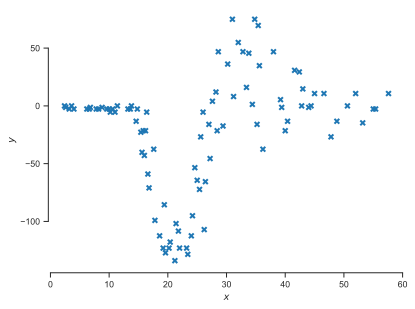

In [4]:
data = np.loadtxt('motor.dat')
X = data[:, 0][:, None]
Y = data[:, 1]

fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
sns.despine(trim=True);

Let's start with polynomial regression.
We need to write code that calculates the design matrix.
Here is the code from the previous section:

In [5]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    cols = []
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

Here is how the design matrix for degree 3 polynomial looks like:

In [6]:
Phi = get_polynomial_design_matrix(X, 3)

print(Phi[:5, :])

[[ 1.     2.4    5.76  13.824]
 [ 1.     2.6    6.76  17.576]
 [ 1.     3.2   10.24  32.768]
 [ 1.     3.6   12.96  46.656]
 [ 1.     4.    16.    64.   ]]


Let's now visualize the polynomials as a function of $x$ so that you get some intuition about how $y$ is expanded:

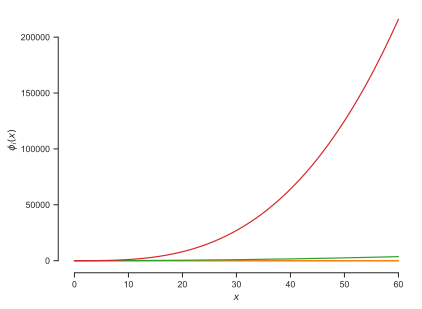

In [7]:
xx = np.linspace(0, 60, 200)
Phi_xx = get_polynomial_design_matrix(xx[:, None], 3)

fig, ax = plt.subplots()
plt.plot(xx, Phi_xx)
plt.ylabel(r'$\phi_i(x)$')
plt.xlabel('$x$')
sns.despine(trim=True);

Let's now solve the least squares problem:

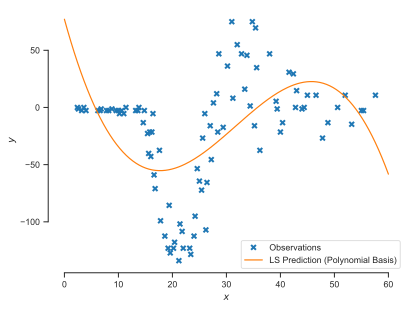

In [9]:
# Fit
degree = 3
Phi = get_polynomial_design_matrix(X, degree)
w_LS = np.linalg.lstsq(Phi, Y, rcond=None)[0]

# Predict
xx = np.linspace(0, 60, 200)
Phi_xx = get_polynomial_design_matrix(xx[:, None], degree)
Y_p = Phi_xx @ w_LS

# Plot
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(xx, Y_p, label='LS Prediction (Polynomial Basis)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=True)
sns.despine(trim=True);

### Questions

+ Experiment with polynomials of degrees 4, 5, 10, 20
+ When are we underfitting?
+ When are we overfitting?
+ Which degree (if any) gives you the best fit?

## Example - Motorcycle data with Fourier basis

Let's repeat what we did with polynomial regression with a Fourier basis.
The mathematical form of the basis is:

$$
\phi_{2j}(x) = \cos\left(\frac{2j\pi}{L}x\right),
$$

and

$$
\phi_{2j+1}(x) = \sin\left(\frac{2j\pi}{L}x\right),
$$

for $j=1,\dots,m/2$.
First, we write code that computes the design matrix for the new basis:

In [10]:
def get_fourier_design_matrix(x, L, num_terms):
    """Fourier expansion with ``num_terms`` cosines and sines.
    
    Arguments:
    x          --  A 2D array with only one column.
    L          --  The "length" of the domain.
    num_terms  --  How many Fourier terms do you want.
                   This is not the number of basis
                   functions you get. The number of basis functions
                   is 1 + num_terms / 2. The first one is a constant.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(int(num_terms / 2)):
        cols.append(np.cos(2 * (i+1) * np.pi / L * x))
        cols.append(np.sin(2 * (i+1) * np.pi / L * x))
    return np.hstack(cols)

Let's start by visualizing the Fourier basis:

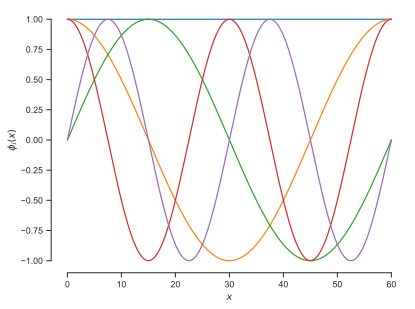

In [11]:
xx = np.linspace(0, 60, 200)
Phi_xx = get_fourier_design_matrix(xx[:, None], 60.0, 4)

fig, ax = plt.subplots()
plt.plot(xx, Phi_xx)
plt.ylabel(r'$\phi_i(x)$')
plt.xlabel('$x$')
sns.despine(trim=True);

Let's now solve the least squares problem:

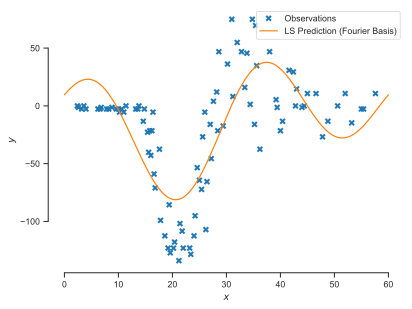

In [12]:
# Fit
L = 60.0
num_terms = 4
Phi = get_fourier_design_matrix(X, L, num_terms)
w_LS = np.linalg.lstsq(Phi, Y, rcond=None)[0]

# Predict
xx = np.linspace(0, 60, 200)
Phi_xx = get_fourier_design_matrix(xx[:, None], L, num_terms)
Y_p = Phi_xx @ w_LS

# Plot
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(xx, Y_p, label='LS Prediction (Fourier Basis)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=True)
sns.despine(trim=True);

### Questions

+ Experiment with 4, 10, 20, 40 terms.
+ When are we underfitting?
+ When are we overfitting?
+ Which one (if any) gives you the best fit?

## Example - Motorcycle data with radial basis functions

Let's now try out the radial basis functions.
The mathematical form is:

$$
\phi_i(x) = \exp\left\{-\frac{(x-x_i^c)^2}{2\ell^2}\right\},
$$

where $x_i^c$ are points about each the basis functions are centered.
We start with the code that evaluates the design matrix:

In [13]:
def get_rbf_design_matrix(x, x_centers, ell):
    """Radial basis functions design matrix.
    
    Arguments:
    x        --  The input points on which you want to evaluate the
                 design matrix.
    x_center --  The centers of the radial basis functions.
    ell      --  The lengthscale of the radial basis function.
    """
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    N = x.shape[0]
    cols = [np.ones((N, 1))]
    for i in range(x_centers.shape[0]):
        cols.append(np.exp(-(x - x_centers[i]) ** 2 / ell))
    return np.hstack(cols)

Now let's visualize the basis:

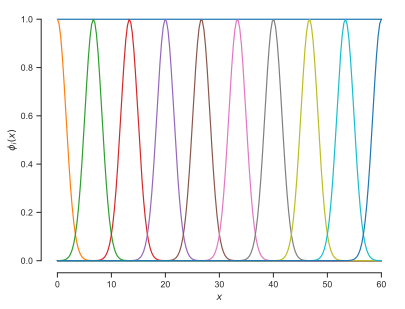

In [14]:
xx = np.linspace(0, 60, 200)
ell = 5.
num_terms = 10
x_centers = np.linspace(0, 60, num_terms)
Phi_xx = get_rbf_design_matrix(xx[:, None], x_centers, ell)

fig, ax = plt.subplots()
plt.plot(xx, Phi_xx)
plt.ylabel(r'$\phi_i(x)$')
plt.xlabel('$x$')
sns.despine(trim=True);

Now let's solve the least squares problem with this basis:

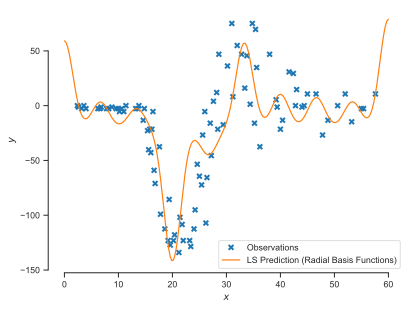

In [15]:
# Fit
Phi = get_rbf_design_matrix(X, x_centers, ell)
w_LS = np.linalg.lstsq(Phi, Y, rcond=None)[0]

# Predict
xx = np.linspace(0, 60, 200)
Phi_xx = get_rbf_design_matrix(xx[:, None], x_centers, ell)
Y_p = Phi_xx @ w_LS

# Plot
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2, label='Observations')
ax.plot(xx, Y_p, label='LS Prediction (Radial Basis Functions)')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=True)
sns.despine(trim=True);

### Questions

+ Experiment with different values of $\ell$ and centers.
+ When are we underfitting?
+ Which one (if any) gives you the best fit?